In [1]:
import glob
import joblib 

import pandas as pd
import numpy as np

import lightgbm as lgb
import xgboost as xgb
import catboost as cbt

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
input_path = './input'

Notebook based on yuanzhe zhou [🥇🥇Jane Street Baseline lgb, xgb and catboost🥇🥇](https://www.kaggle.com/code/yuanzhezhou/jane-street-baseline-lgb-xgb-and-catboost) and motono0223 [EDA: Jane Street Real-Time Market Data Forecasting](https://www.kaggle.com/code/motono0223/eda-jane-street-real-time-market-data-forecasting)

## EDA

### Dataset description

The dataset comprises a set of timeseries with 79 features and 9 responders, anonymized but representing real market data. The goal is to forecast one of these responders, i.e., responder_6, for up to six months in the future.

### Features

* **features.csv** - metadata pertaining to the anonymized features* 

In [3]:
features = pd.read_csv(f"{input_path}/features.csv")
features

,feature,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16
0,feature_00,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,True
1,feature_01,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,True
2,feature_02,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True
3,feature_03,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True
4,feature_04,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,feature_74,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
75,feature_75,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
76,feature_76,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
77,feature_77,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False


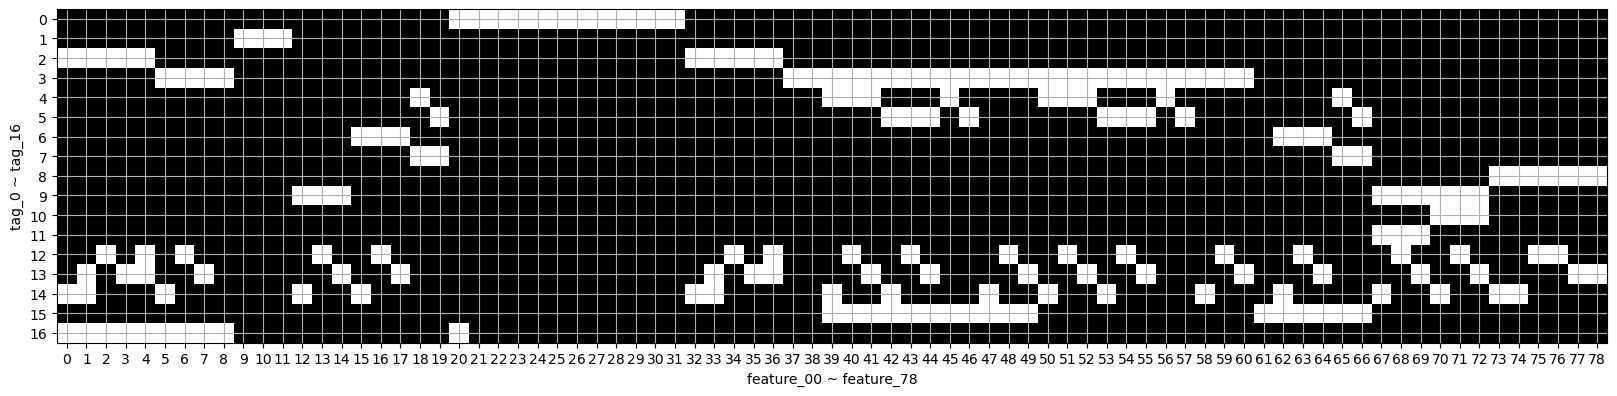

In [4]:
plt.figure(figsize=(20, 10))
plt.imshow(features.iloc[:, 1:].T.values, cmap="gray")
plt.xlabel("feature_00 ~ feature_78")
plt.ylabel("tag_0 ~ tag_16")
plt.yticks(np.arange(17))
plt.xticks(np.arange(79))
plt.grid()
plt.show()

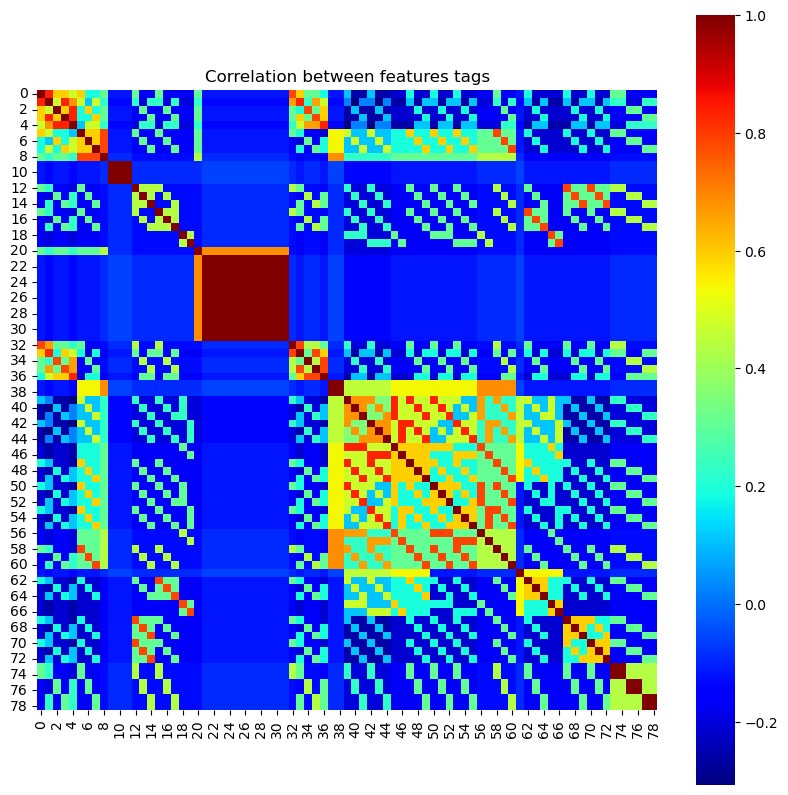

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(features[[f"tag_{no}" for no in range(17)]].T.corr(), square=True, cmap="jet")
plt.title('Correlation between features tags')
plt.show()

### Responders

* **responders.csv** - metadata pertaining to the anonymized responders

In [6]:
responders = pd.read_csv(f"{input_path}/responders.csv")
responders

,responder,tag_0,tag_1,tag_2,tag_3,tag_4
0,responder_0,True,False,True,False,False
1,responder_1,True,False,False,True,False
2,responder_2,True,True,False,False,False
3,responder_3,False,False,True,False,True
4,responder_4,False,False,False,True,True
5,responder_5,False,True,False,False,True
6,responder_6,False,False,True,False,False
7,responder_7,False,False,False,True,False
8,responder_8,False,True,False,False,False


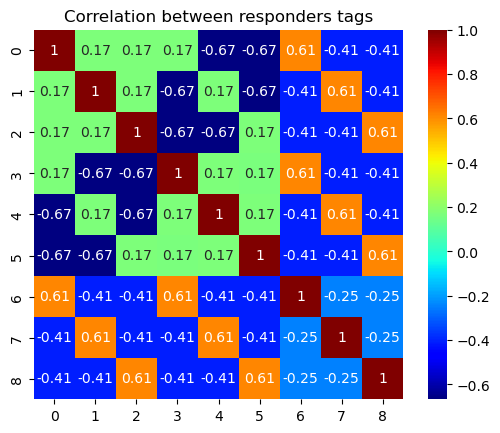

In [7]:
sns.heatmap(responders[[f"tag_{no}" for no in range(5)]].T.corr(), annot=True, square=True, cmap="jet")
plt.title('Correlation between responders tags')
plt.show()

### Train.parquet

* **train.parquet** - The training set, contains historical data and returns. For convenience, the training set has been partitioned into ten parts.
    *  `date_id` and `time_id` - Integer values that are ordinary sorted, providing a chronological structure to the data, although the actual time intervals between `time_id` values may vary.
    *  `symbol_id` - Identifies a unique financial instrument.
    *  `weight` - The weighting used for calculating the scoring function.
    *  `feature_{00...78}` - Anonymized market data.
    *  `responder_{0...8}` - Anonymized responders clipped between -5 and 5. The responder_6 field is what you are trying to predict.

## Data preparation and visualisation

In [3]:
FILL_MISSING_VALUES = False
CUT_OUTLIERS = False

In [4]:
feature_names = [f"feature_{i:02d}" for i in range(79)]
partitions = glob.glob(f"{input_path}/train.parquet/*/*.parquet")
partitions.sort()
partitions_to_read = 2

In [5]:
def reduce_mem_usage(df, float16_as32=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type) != 'category':
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                int8 = np.iinfo(np.int8)
                int16 = np.iinfo(np.int16)
                int32 = np.iinfo(np.int32)
                if c_min > int8.min and c_max < int8.max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > int16.min and c_max < int16.max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > int32.min and c_max < int32.max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                float16 = np.finfo(np.float16)
                float32 = np.finfo(np.float32)
                if c_min > float16.min and c_max < float16.max and not float16_as32:
                    df[col] = df[col].astype(np.float16)         
                elif c_min > float32.min and c_max < float32.max:
                    df[col] = df[col].astype(np.float32)     
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [10]:
df = pd.concat([pd.read_parquet(partitions[i]) for i in range(partitions_to_read)], ignore_index=True)
reduce_mem_usage(df, False)

Memory usage of dataframe is 1598.55 MB
Memory usage after optimization is 928.34 MB
Decreased by 41.9%


### Features

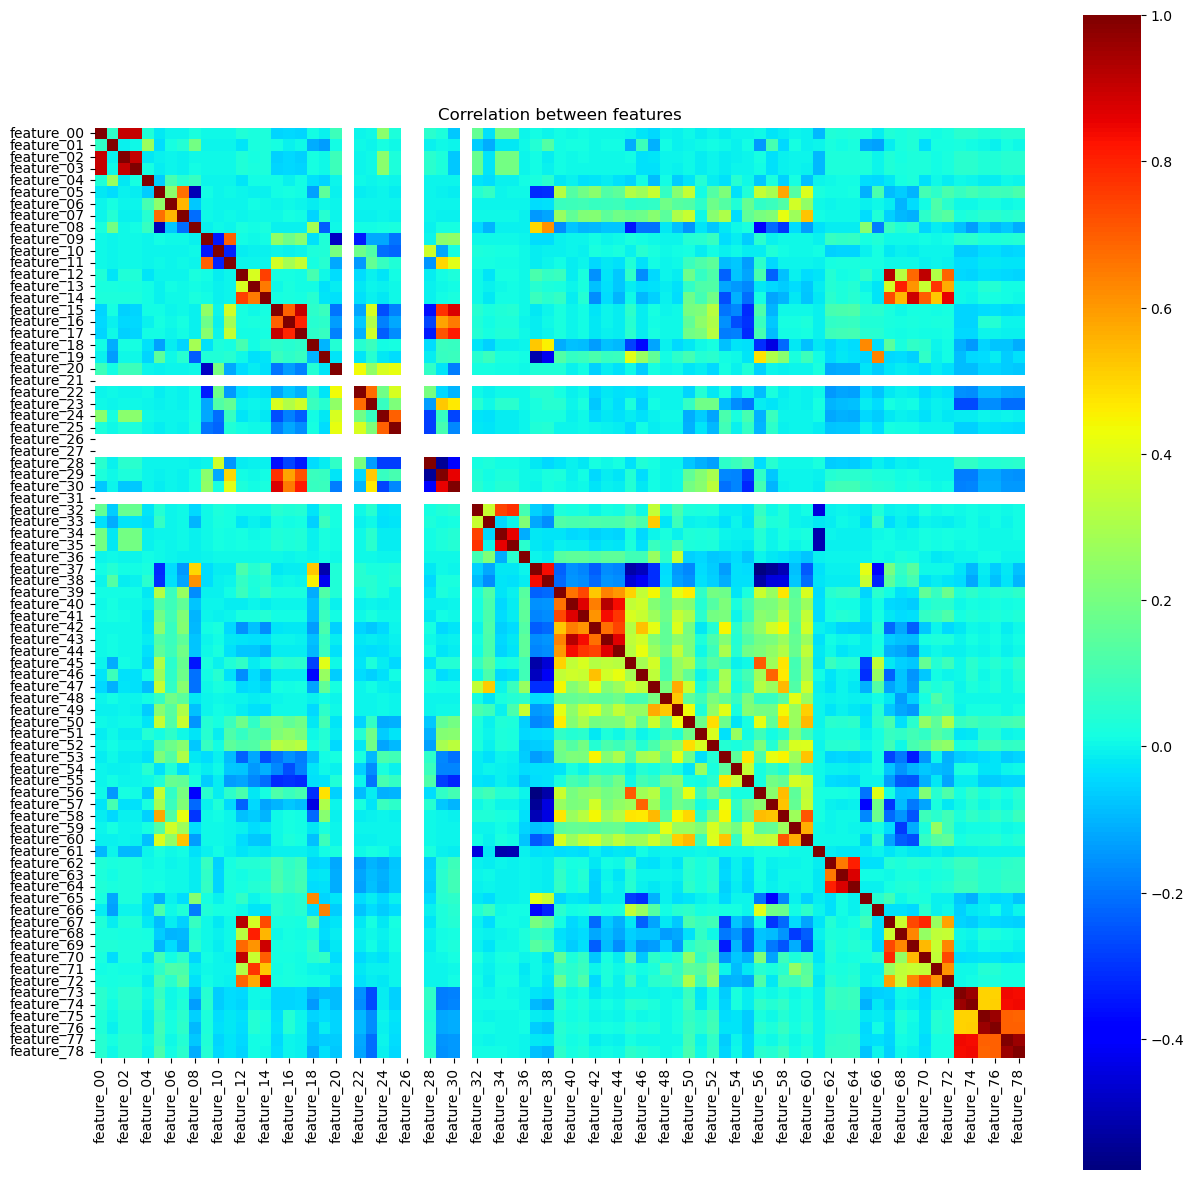

In [11]:
plt.figure(figsize=(15, 15))
sns.heatmap(df[[f"feature_{target:02d}" for target in range(79)]].corr(), square=True, cmap="jet")
plt.grid
plt.title('Correlation between features')
plt.show()

### Responder

/home/marko/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/marko/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


column = responder_6
mean: -0.0000
sigma: 0.0000
min: -5.000000
max: 5.0000


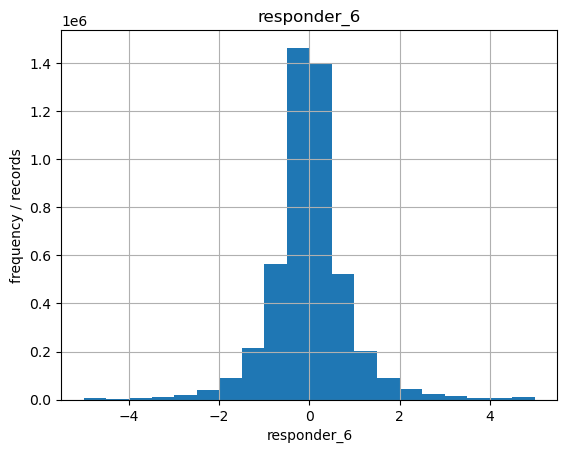

In [12]:
col = "responder_6"
mean_, sgm_ = df[col].mean(), np.sqrt(df[col].var())
min_, max_ = df[col].min(), df[col].max()
print(f"column = {col}")
print(f"mean: {mean_:.4f}")
print(f"sigma: {sgm_:.4f}")
print(f"min: {min_:4f}")
print(f"max: {max_:.4f}")

plt.hist(df[col], bins=20)
plt.xlabel(col)
plt.ylabel("frequency / records")
plt.grid()
plt.title("responder_6")
plt.show()

### symbol_id

symbol_id:  0 - 38


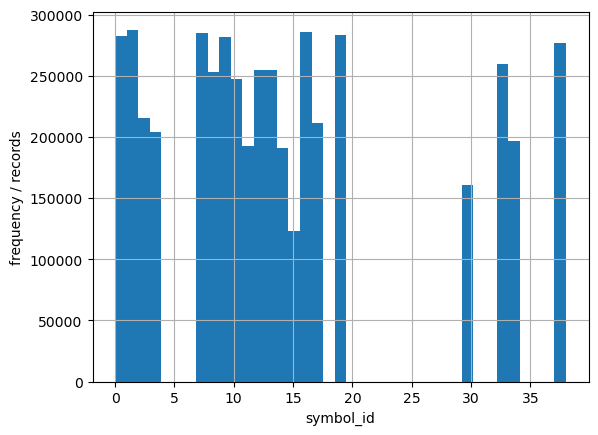

In [13]:
symbol_min = df["symbol_id"].min()
symbol_max = df["symbol_id"].max()
print(f"symbol_id: ", symbol_min, "-", symbol_max)
bins = symbol_max - symbol_min + 1
plt.hist(df["symbol_id"], bins=bins)
plt.xlabel("symbol_id")
plt.ylabel("frequency / records")
plt.grid()
plt.show()

### date_id

date_id:  0 - 339


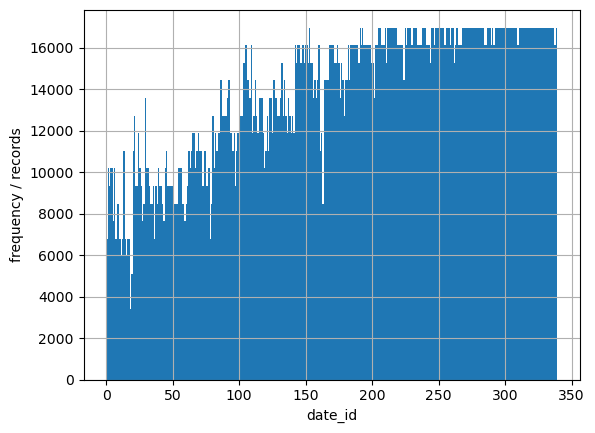

In [14]:
date_min = df["date_id"].min()
date_max = df["date_id"].max()
print(f"date_id: ", date_min, "-", date_max)
bins = date_max - date_min + 1
plt.hist(df["date_id"], bins=bins)
plt.xlabel("date_id")
plt.ylabel("frequency / records")
plt.grid()
plt.show()

## Data cleaning

### Missing values

In [6]:
if FILL_MISSING_VALUES:
    columns_with_missing_values = df.columns[df.isnull().any()]
    col_miss_exists = len(columns_with_missing_values) > 0
    print(f"Columns with missing values{'' if col_miss_exists else ' not'} exists")
    df = df.fillna(0)
    columns_with_missing_values = df.columns[df.isnull().any()]
    # print(len(columns_with_missing_values) > 0)

### Outliers

In [16]:
# outliers_sum = 0
# for feature in feature_names:
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     small = df[feature] < (Q1 - 1.5 * IQR)
#     big = df[feature] > (Q3 + 1.5 * IQR)
#     outliers = df[small | big].shape[0]
#     outliers_sum += outliers
#     # print(f"Outliers in {feature}: {outliers}, {round(outliers/df.shape[0], 3)*100}%")
# mean_outliers_percent = outliers_sum / len(feature_names) / df.shape[0]
# print(f"Outliers mean average percent is {round(mean_outliers_percent, 3)}")

In [8]:
if CUT_OUTLIERS:
    for feature in feature_names:
        lower_bound = df[feature].quantile(0.05)
        upper_bound = df[feature].quantile(0.95)
        df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
        df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])

## Modelling

In [11]:
dates = df['date_id'].unique()
n = len(dates)
train_end = int(n * 0.6)
val_end = train_end + int(n * 0.2)
train_dates = dates[:train_end]
val_dates = dates[train_end:val_end]
test_dates = dates[val_end:]

In [12]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [13]:
def get_X_y_w(df, dates):
    X = df[feature_names].loc[df['date_id'].isin(dates)]
    y = df['responder_6'].loc[df['date_id'].isin(dates)]
    w = df['weight'].loc[df['date_id'].isin(dates)]
    return X,y,w

In [14]:
X_train, y_train, w_train = get_X_y_w(df, train_dates)
X_valid, y_valid, w_valid = get_X_y_w(df, val_dates)
X_test, y_test, w_test = get_X_y_w(df, test_dates)

$R^2 = 1 - \frac{RSS}{TSS}$

In [15]:
e = 1e-38

In [16]:
def r2_xgb(y_true, y_pred, sample_weight):
    rss = np.average((y_pred - y_true) ** 2, weights=sample_weight)
    tss = np.average(y_true ** 2, weights=sample_weight)
    r2 = 1 - rss/tss + e
    return -r2

In [17]:
def r2_lgb(y_true, y_pred, sample_weight):
    rss = np.average((y_pred - y_true) ** 2, weights=sample_weight)
    tss = np.average(y_true ** 2, weights=sample_weight)
    r2 = 1 - rss/tss + e
    return 'r2', r2, True

In [18]:
class r2_cbt(object):
    def get_final_error(self, error, weight):
        return 1 - error / (weight + e)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        approx = approxes[0]
        error_sum = 0.0
        weight_sum = 0.0
        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w * (target[i] ** 2)
            error_sum += w * ((approx[i] - target[i]) ** 2)
        return error_sum, weight_sum

In [19]:
model_dict = {}

**LightGBM** is a gradient boosting framework that uses tree based learning algorithms

In [20]:
model_dict['lgb'] = lgb.LGBMRegressor(n_estimators=500, objective='l2', gpu_use_dp=True)
model_dict['lgb'].fit(X_train, y_train, w_train, 
          eval_metric=[r2_lgb],
          eval_set=[(X_valid, y_valid, w_valid)],
          callbacks=[
              lgb.early_stopping(100),
              lgb.log_evaluation(10)
          ]
         )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.040424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17066
[LightGBM] [Info] Number of data points in the train set: 2473137, number of used features: 70
[LightGBM] [Info] Start training from score -0.001439
Training until validation scores don't improve for 100 rounds
[10]	valid_0's l2: 0.73606	valid_0's r2: 0.00913778
[20]	valid_0's l2: 0.734794	valid_0's r2: 0.010841
[30]	valid_0's l2: 0.733913	valid_0's r2: 0.0120275
[40]	valid_0's l2: 0.733535	valid_0's r2: 0.0125364
[50]	valid_0's l2: 0.733305	valid_0's r2: 0.0128464
[60]	valid_0's l2: 0.733411	valid_0's r2: 0.0127029
[70]	valid_0's l2: 0.733376	valid_0's r2: 0.0127499
[80]	valid_0's l2: 0.733546	valid_0's r2: 0.0125217
[90]	valid_0's l2: 0.733631	valid_0's r2: 0.0124074
[100]	valid_0's l2: 0.733862	valid_0's r2: 0.0120959
[110]	valid_0's l2: 0.733761	valid_0's r2: 0.0122319
[120]	valid_0's l2:

LGBMRegressor(gpu_use_dp=True, n_estimators=500, objective='l2')

**XGBoost** is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.

In [21]:
model_dict['xgb'] = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.1, max_depth=6, 
                                     tree_method='hist', device="cuda",
                                     objective='reg:squarederror', eval_metric=r2_xgb,
                                     disable_default_eval_metric=True,
                                     early_stopping_rounds=100
                                    )
model_dict['xgb'].fit(X_train, y_train, sample_weight=w_train,
                     eval_set=[(X_valid, y_valid)],
                      sample_weight_eval_set=[w_valid],
                      verbose=10,
                     )

/home/marko/miniconda3/envs/ml-zoomcamp/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:10:27] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-r2_xgb:-0.00186
[10]	validation_0-r2_xgb:-0.00937
[20]	validation_0-r2_xgb:-0.01077
[30]	validation_0-r2_xgb:-0.01067
[40]	validation_0-r2_xgb:-0.01118
[50]	validation_0-r2_xgb:-0.01104
[60]	validation_0-r2_xgb:-0.00745
[70]	validation_0-r2_xgb:-0.00558
[80]	validation_0-r2_xgb:-0.00470
[90]	validation_0-r2_xgb:-0.00218
[100]	validation_0-r2_xgb:-0.00136
[110]	validation_0-r2_xgb:-0.00089
[120]	validation_0-r2_xgb:0.00629
[130]	validation_0-r2_xgb:0.00628
[140]	validation_0-r2_xgb:0.00694
[142]	validation_0-r2_xgb:0.00712


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda',
             disable_default_eval_metric=True, early_stopping_rounds=100,
             enable_categorical=False,
             eval_metric=<function r2_xgb at 0x795dfccd8220>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)

CatBoost is a high-performance open source library for gradient boosting on decision trees

In [22]:
model_dict['cbt'] = cbt.CatBoostRegressor(iterations=1000, learning_rate=0.05,  
                                          loss_function='RMSE', 
                                          eval_metric=r2_cbt(),
                                         )
evalset = cbt.Pool(X_valid, y_valid, weight=w_valid)
model_dict['cbt'].fit(X_train, y_train, sample_weight=w_train,
         eval_set=[evalset],
         verbose=10,
         early_stopping_rounds=100)

0:	learn: 0.0009979	test: 0.0007555	best: 0.0007555 (0)	total: 3.65s	remaining: 1h 42s
10:	learn: 0.0075348	test: 0.0053476	best: 0.0053476 (10)	total: 10.3s	remaining: 15m 29s
20:	learn: 0.0109696	test: 0.0074057	best: 0.0074057 (20)	total: 17.1s	remaining: 13m 18s
30:	learn: 0.0134309	test: 0.0085490	best: 0.0085490 (30)	total: 23.5s	remaining: 12m 13s
40:	learn: 0.0154002	test: 0.0094524	best: 0.0094524 (40)	total: 29.2s	remaining: 11m 21s
50:	learn: 0.0173285	test: 0.0101527	best: 0.0101527 (50)	total: 34.9s	remaining: 10m 48s
60:	learn: 0.0188386	test: 0.0105549	best: 0.0105549 (60)	total: 40.5s	remaining: 10m 23s
70:	learn: 0.0206728	test: 0.0108828	best: 0.0108828 (70)	total: 46s	remaining: 10m 1s
80:	learn: 0.0221381	test: 0.0109537	best: 0.0109537 (80)	total: 51.3s	remaining: 9m 42s
90:	learn: 0.0233590	test: 0.0113602	best: 0.0113602 (90)	total: 57.5s	remaining: 9m 34s
100:	learn: 0.0245838	test: 0.0117184	best: 0.0117184 (100)	total: 1m 2s	remaining: 9m 19s
110:	learn: 0.025

In [23]:
model_names = ['lgb', 'xgb', 'cbt']
for model_name in model_names:
    joblib.dump(model_dict[model_name], f'./models/{model_name}.model')

In [24]:
cbt_score = model_dict['cbt'].get_best_score()['validation']['r2_cbt']
print("CatBoost score ", round(cbt_score, 4))
xgb_score = -model_dict['xgb'].best_score
print("XGB score ", round(xgb_score, 4))
lgb_score = model_dict['lgb'].best_score_["valid_0"]['r2']
print("LGMB score ", round(lgb_score, 4))

CatBoost score  0.0128
XGB score  0.0112
LGMB score  0.0129


In [25]:
model = model_dict['lgb']

## Feature importance analysis

In [26]:
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': model.feature_name_,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance')
importance_df

,Feature,Importance
0,feature_00,0
27,feature_27,0
31,feature_31,0
26,feature_26,0
21,feature_21,0
...,...,...
22,feature_22,73
60,feature_60,79
38,feature_38,81
7,feature_07,85


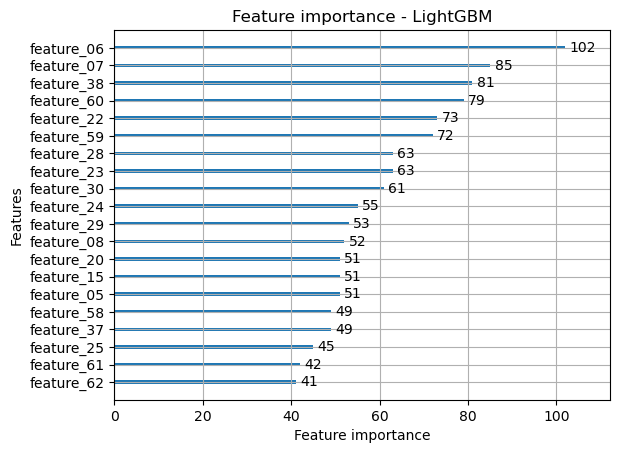

: 

In [ ]:
lgb.plot_importance(model, max_num_features=20)
plt.title("Feature importance - LightGBM")
plt.show()